In [215]:
from networkx.algorithms.bipartite.basic import color

# Dataset Directory

dataset_folder = '/mnt/Data1/Nick/transcription_pipeline/'

Rpb1_datasets = [
    "test_data/2024-10-11/Halo552_Rpb1_embryo03"
]

Dl_datasets = [
    "test_data/2024-11-08/Dl-Halo552_MCP-GFP_twiPE_embryo01",
    "test_data/2024-11-20/Dl-Halo552_MCP-GFP_twiPE_embryo01",
]

test_dataset_name = dataset_folder + Dl_datasets[1]
print('Dataset Path: ' + test_dataset_name)

Dataset Path: /mnt/Data1/Nick/transcription_pipeline/test_data/2024-11-20/Dl-Halo552_MCP-GFP_twiPE_embryo01


In [216]:
# Import pipeline
from transcription_pipeline import nuclear_pipeline
from transcription_pipeline import preprocessing_pipeline

from transcription_pipeline import spot_pipeline
from transcription_pipeline import fullEmbryo_pipeline

# Importing libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from transcription_pipeline.spot_analysis import compile_data
from transcription_pipeline.utils import plottable

from scipy.signal import medfilt
from skimage.restoration import denoise_tv_chambolle

import numpy as np
from scipy.optimize import least_squares
from scipy.stats import chi2
import pandas as pd
from IPython.display import display
import emcee
import os
from warnings import warn
import tkinter as tk
from tkinter import simpledialog
from tkinter import messagebox

root = tk.Tk()
root.withdraw();

In [ ]:
mpl.use('TkAgg')
# %matplotlib widget

In [217]:
ms2_import_previous = os.path.isdir(test_dataset_name + '/collated_dataset')
ms2_import_previous

True

In [218]:
dataset = preprocessing_pipeline.DataImport(
    name_folder=test_dataset_name,
    trim_series=True,
    working_storage_mode='zarr',
    import_previous=ms2_import_previous, 
)

In [ ]:
from dask.distributed import LocalCluster, Client

try:
    cluster = LocalCluster(
        host="localhost",
        scheduler_port=37763,
        threads_per_worker=1,
        n_workers=14,
        memory_limit="10GB",
    )
    
    client = Client(cluster)
except:
    print("Cluster already running")
    client = Client('localhost:37763')

print(client)

In [ ]:
client.restart()

In [ ]:
client.shutdown()

In [ ]:
print(client.dashboard_link)

## Check the dataset

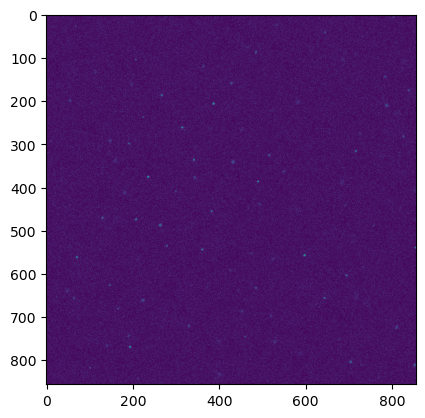

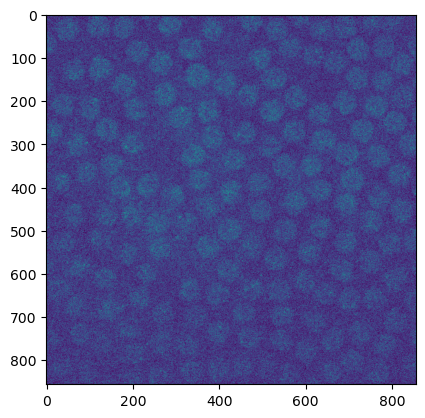

In [219]:
# Plot both channels of the movie in line

%matplotlib inline
time_frame = 3
z_slice = 8

plt.figure()
plt.imshow(dataset.channels_full_dataset[0][time_frame, z_slice, :, :])
plt.show()

plt.figure()
plt.imshow(dataset.channels_full_dataset[1][time_frame, z_slice, :, :])
plt.show()

In [220]:
# Set the channels for spot and nuclear tracking
spot_channel = 0
nuclear_channel = 1

## Spot Tracking

In [221]:
spot_tracking_previous = os.path.isdir(test_dataset_name + '/spot_analysis_results')
spot_tracking_previous

True

In [222]:
%%time

if spot_tracking_previous:
    # Load spot tracking results
    print('Load from spot  tracking results')
    
    spot_tracking = spot_pipeline.Spot()
    spot_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do spot tracking and save the results
    print('Do spot tracking for the dataset')
    
    spot_tracking = spot_pipeline.Spot(
        data=dataset.channels_full_dataset[spot_channel],
        global_metadata=dataset.export_global_metadata[spot_channel],
        frame_metadata=dataset.export_frame_metadata[spot_channel],
        labels=None,#nuclear_tracking.reordered_labels,
        expand_distance=3,
        search_range_um=4.2,
        retrack_search_range_um=4.5,
        threshold_factor=1.3,
        memory=3,
        retrack_after_filter=False,
        stitch=True,
        min_track_length=0,
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        keep_bandpass=False,
        keep_futures=False,
        keep_spot_labels=False,
        evaluate=True,
        retrack_by_intensity=True,
        client=client,
    )
    
    spot_tracking.extract_spot_traces(
        working_memory_folder=test_dataset_name, 
        stitch=True,
        retrack_after_filter=True,
        trackpy_log_path = test_dataset_name+'/trackpy_log'
    )
    
    # Saves tracked spot mask as a zarr, and pickles dataframes with spot fitting and
    # quantification information.
    spot_tracking.save_results(name_folder=test_dataset_name, save_array_as=None)

Load from spot  tracking results
CPU times: user 299 ms, sys: 28.9 ms, total: 328 ms
Wall time: 912 ms


In [223]:
# Load spot tracking dataframe
spot_df = spot_tracking.spot_dataframe

# Remove spots that were not detected
detected_spots = spot_df[spot_df["particle"] != 0]

# Compile traces
compiled_dataframe = compile_data.compile_traces(
    detected_spots,
    compile_columns_spot=[
        "frame",
        "t_s",
        "intensity_from_neighborhood",
        "intensity_std_error_from_neighborhood",
        "x",
        "y",
        "z"
    ],
    nuclear_tracking_dataframe=None,
)

compiled_dataframe.head()

,particle,frame,t_s,intensity_from_neighborhood,intensity_std_error_from_neighborhood,x,y,z
0,1,"[51, 54, 59, 60, 61, 62, 68]","[1973.5479984283447, 2060.775999069214, 2196.8...","[2.4812413793103425, 18.35352427184466, 324.72...","[79.20597865194743, 73.68995860554239, 81.8350...","[383.3225432436862, 370.6492413599677, 340.881...","[101.7529245727801, 132.3176149682195, 144.524...","[2.8724155633989006, 4.922880933388404, 3.1229..."
1,2,"[65, 66, 67, 68]","[2364.55299949646, 2396.0049991607666, 2423.97...","[229.4812536764706, 224.40127118644065, 237.24...","[85.21771622174803, 75.40730368740091, 69.4800...","[278.4758258825609, 277.7118243153448, 277.301...","[142.16702865008267, 142.4375705103173, 143.67...","[2.4578648654562385, 5.474005624682677, 5.0306..."
2,3,"[50, 51, 52, 53, 54, 55, 56, 58, 62, 63, 64, 6...","[1945.6319999694824, 1973.5479984283447, 2003....","[67.81412025316456, 163.98577044025157, 148.50...","[82.68656041041959, 69.47519552415157, 76.4980...","[841.7353891457661, 838.8587548538217, 839.997...","[198.72048429517127, 199.82621880615687, 197.0...","[3.0922917998425743, 3.467288555979153, 3.5289..."
3,4,"[56, 57, 58, 59, 64, 65, 66, 67, 68]","[2113.1199989318848, 2142.781000137329, 2168.9...","[460.85320382165605, 695.6611308724832, 861.89...","[80.99762673665634, 81.74797152036892, 81.0868...","[603.6137543833868, 601.0465443559206, 602.564...","[247.61666067147598, 251.26279817459212, 254.6...","[2.886385356276063, 3.7587880291493403, 2.8779..."
4,5,"[30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 4...","[1349.0399990081787, 1404.8719997406006, 1460....","[116.3118566552901, 473.50356401384084, 649.22...","[79.71776174806152, 88.27060274126882, 93.0425...","[121.97276077495263, 133.39091471838816, 141.7...","[199.33893022694244, 173.89256526512887, 175.2...","[4.197487954706576, 4.026833253040332, 3.77808..."


In [224]:
detected_spots[detected_spots["particle"] == 140]

,label,z,y,x,frame,t_s,t_frame,raw_spot,coordinates_start,covariance_matrix,...,offset,cost,norm_cost,intensity_from_fit,intensity_std_error_from_fit,intensity_from_neighborhood,intensity_std_error_from_neighborhood,background_intensity_from_neighborhood,background_intensity_std_error_from_neighborhood,particle
9026,142,6.120549,124.257363,496.676023,42,1727.543999,61,"[[[1, 2, 0, 3, 3, 2, 0, 0, 2, 4, 2, 0, 1, 1, 1...","[2, 3, 114, 487]","[[0.02335981752054213, 9.48306660255316e-08, 1...",...,1.347211,1510.213737,0.010078,358.880161,51.223872,324.331772,77.889873,1.335932,0.064478,140
9299,179,6.970035,119.150338,497.165404,43,1757.195999,62,"[[[1, 1, 2, 4, 2, 2, 2, 1, 0, 3, 1, 1, 0, 2, 2...","[0, 4, 109, 487]","[[0.004294663671607581, 6.5656062922931564e-12...",...,1.374313,1427.529173,0.004802,231.533616,22.455766,359.508443,80.813839,1.294847,0.066177,140
9556,186,7.029438,119.416931,498.000140,44,1785.112000,63,"[[[2, 1, 1, 0, 2, 2, 1, 2, 0, 1, 1, 0, 1, 3, 1...","[1, 4, 109, 488]","[[0.0027982454304987226, 7.608023117190144e-12...",...,1.312879,1423.063588,0.003292,417.360267,25.353359,584.149360,76.793834,1.199110,0.063508,140
9799,169,7.792648,119.930035,494.326040,45,1814.771999,64,"[[[1, 0, 0, 1, 3, 1, 1, 3, 3, 2, 0, 1, 4, 1, 4...","[2, 5, 110, 484]","[[0.00548345372074198, 6.420834194346964e-12, ...",...,1.399268,1569.370599,0.004399,403.238883,30.228231,437.721102,86.313097,1.361912,0.073264,140
10061,186,8.426027,118.347276,494.123450,46,1842.688000,65,"[[[1, 2, 0, 3, 4, 0, 1, 0, 2, 1, 1, 1, 2, 3, 1...","[0, 5, 109, 484]","[[0.008091407629702195, -7.379263484079839e-10...",...,1.313900,1503.531963,0.005118,602.686846,48.557902,607.247101,73.728813,1.254834,0.062383,140
10343,236,8.920717,119.564622,493.845415,47,1872.348000,66,"[[[3, 1, 0, 0, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 1...","[1, 6, 110, 484]","[[0.0027762820369019348, 3.3154577028448942e-1...",...,1.342198,1563.136380,0.003712,479.980184,30.095303,593.054158,76.442315,1.267182,0.059187,140
10590,225,9.748151,118.880571,494.546612,48,1902.000000,68,"[[[2, 0, 1, 1, 3, 1, 2, 0, 3, 0, 0, 3, 1, 0, 2...","[2, 7, 109, 485]","[[0.0034501917353480702, 1.0358647413819628e-1...",...,1.355831,1582.078675,0.003434,468.038228,28.381213,625.471338,77.331669,1.262603,0.061931,140
10840,221,9.880711,116.993256,490.273129,49,1929.915998,69,"[[[1, 1, 2, 2, 1, 1, 1, 0, 3, 2, 2, 1, 1, 2, 2...","[0, 7, 107, 480]","[[0.005096577921173604, 1.1931884246562652e-08...",...,1.314194,1706.711786,0.005419,626.513867,47.510784,617.791793,86.266031,1.304807,0.066149,140
11102,237,9.059478,117.750297,494.643006,50,1956.087999,69,"[[[2, 0, 2, 1, 3, 0, 1, 1, 2, 2, 0, 3, 0, 0, 1...","[1, 6, 108, 485]","[[0.0017956887877977755, 3.7106140818722816e-1...",...,1.328056,1614.855710,0.002883,693.427225,32.897487,545.966909,83.919502,1.424770,0.068961,140
11297,166,8.625920,120.016009,491.354702,51,1982.260000,70,"[[[0, 1, 1, 0, 4, 0, 2, 0, 2, 1, 0, 0, 2, 1, 2...","[2, 5, 110, 481]","[[0.006533425866721117, 4.060804287025917e-12,...",...,1.420907,1712.575417,0.002734,775.727104,45.383632,645.539570,77.634623,1.397436,0.067079,140


In [225]:
traces_compiled_dataframe = compiled_dataframe[
    compiled_dataframe["frame"].apply(lambda x: x.size) > 0
]

In [ ]:
mpl.use('TkAgg')

In [ ]:
# Copied from Nick's Analysis Notebook

# The part of the code for scrolling between plots is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots

traces = plottable.generate_trace_plot_list(traces_compiled_dataframe)
#median_filtered_traces = [medfilt(trace[1], kernel_size=15) for trace in traces]

tv_denoised_traces = [
    denoise_tv_chambolle(trace[1], weight=1080, max_num_iter=500) for trace in traces
]
# potts_steps_traces = [
#     potts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]


# plt.close()
# plt.plot(traces[curr_pos][0], traces[curr_pos][1], label="Original")otts_l1.l1_potts_step_detection(trace[1], gamma=-5e3, weights=(1 / trace[2] ** 2))
#     for trace in traces
# ]

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.errorbar(
        traces[curr_pos][0],
        traces[curr_pos][1],
        yerr=traces[curr_pos][2],
        fmt=".",
        elinewidth=1,
    )
    # ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
    ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
    # ax.step(
    #     traces[curr_pos][0],
    #     potts_steps_traces[curr_pos],
    #     where="mid",
    #     color="red",
    #     label="Potts L1",
    # )
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")

    particle = traces[curr_pos][3]
    mean_x = (
        compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
        .values[0]
        .mean()
    )
    initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
    )
    ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
    ax.legend()
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.errorbar(
    traces[curr_pos][0],
    traces[curr_pos][1],
    yerr=traces[curr_pos][2],
    fmt=".",
    elinewidth=1,
)
# ax.plot(traces[curr_pos][0], median_filtered_traces[curr_pos], color="k")
ax.plot(traces[curr_pos][0], tv_denoised_traces[curr_pos], color="k", label="TV")
# ax.step(
#     traces[curr_pos][0],
#     potts_steps_traces[curr_pos],
#     where="mid",
#     color="red",
#     label="Potts L1",
# )
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")

particle = traces[curr_pos][3]
mean_x = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "x"]
    .values[0]
    .mean()
)
initial_frame = (
    compiled_dataframe.loc[compiled_dataframe["particle"] == particle, "frame"]
    .values[0][0]
)
ax.set_title(f"Particle {particle}, x = {mean_x}, Initial frame {initial_frame}")
ax.legend()

plt.show()

## Nuclear Tracking

In [226]:
nuclear_tracking_previous = os.path.isdir(test_dataset_name + '/nuclear_analysis_results')
nuclear_tracking_previous

True

In [227]:
if nuclear_tracking_previous:
    # Load nuclear tracking results
    print('Load from previous nuclear tracking results')
    
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)
    
else:
    # Do nuclear tracking and save the results
    print('Do nuclear tracking for the dataset')
    
    nuclear_tracking = nuclear_pipeline.Nuclear(
        data=dataset.channels_full_dataset[nuclear_channel],
        global_metadata=dataset.export_global_metadata[nuclear_channel],
        frame_metadata=dataset.export_frame_metadata[nuclear_channel],
        series_splits=dataset.series_splits,
        series_shifts=dataset.series_shifts,
        search_range_um=1.5,
        stitch=False,
        stitch_max_distance=4,
        stitch_max_frame_distance=2,
        client=client,
        keep_futures=False,
    )
    
    nuclear_tracking.track_nuclei(
            working_memory_mode="zarr",
            working_memory_folder=test_dataset_name,
            trackpy_log_path="".join([test_dataset_name, "trackpy_log"]),
        )
        # Saves tracked nuclear mask as a zarr, and pickles dataframes with segmentation and
        # tracking information.
    nuclear_tracking.save_results(
            name_folder=test_dataset_name, save_array_as=None
        )

Load from previous nuclear tracking results


In [228]:
    # Load nuclear tracking results
    nuclear_tracking = nuclear_pipeline.Nuclear()
    nuclear_tracking.read_results(name_folder=test_dataset_name)

In [229]:
nuclear_tracking.mitosis_dataframe.head()

,label,z,y,x,nuclear_intensity_mean,nuclear_intensity_stdev,frame,original_frame,t_s,t_frame,nuclear_cycle,y_pixel,x_pixel,particle,v_z,v_y,v_x,parent
0,1,5.696124,1.358253,3.140543,2.321327,1.555482,68,68,2453.688999,87,NaN,12.587064,29.103721,1,0.137431,-0.060401,0.499471,<NA>
1,2,2.280690,1.058130,16.289851,2.332216,1.533939,68,68,2448.445000,87,NaN,9.805795,150.959633,2,-0.624346,0.043959,-0.870002,<NA>
2,3,2.899697,0.933279,21.167982,2.298127,1.543610,68,68,2448.445000,87,NaN,8.648785,196.165748,3,-0.756977,-0.058002,-1.407905,<NA>
3,4,4.383867,1.149931,33.764528,2.293050,1.520194,68,68,2451.941000,87,NaN,10.656525,312.899168,4,-0.076986,0.225449,-0.790909,<NA>
4,5,3.625642,0.939010,43.245417,2.320752,1.533382,68,68,2450.192999,87,NaN,8.701894,400.759487,5,0.401833,-0.250227,1.359950,<NA>


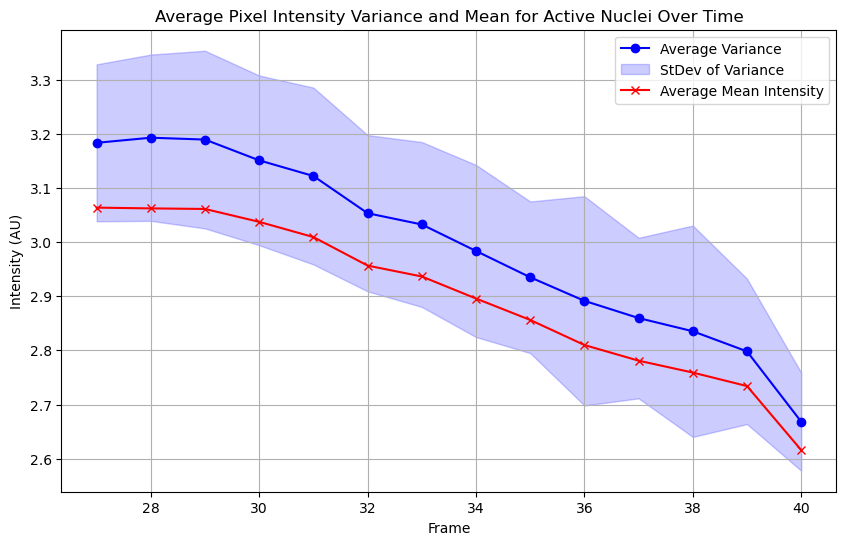

In [267]:
import numpy as np
import matplotlib.pyplot as plt

def plot_timewise_nucleus_intensity_variance_with_sem(df, data, mask, start_time, end_time):
    """
    Plots the mean pixel intensity variance and mean intensity over time,
    with the standard error of the mean (SEM) for the variance shown as a shaded region.

    Parameters:
    df (pd.DataFrame): DataFrame containing centroid coordinates ('time', 'z', 'y', 'x') in pixels.
    data (np.ndarray): 4D dataset with shape (t, z, y, x).
    mask (np.ndarray): 3D mask with labeled nuclei.
    start_time (int): Start time frame.
    end_time (int): End time frame.
    """
    timepoints = np.arange(start_time, end_time + 1)
    mean_variances = []
    sem_variances = []  # Standard error of the mean for variances
    mean_intensities = []
    
    for t in timepoints:
        # Filter for nuclei active at the current time point
        nuclei_at_t = df[df['frame'] == t]
        
        if nuclei_at_t.empty:
            mean_variances.append(np.nan)
            sem_variances.append(np.nan)
            mean_intensities.append(np.nan)
            continue
        
        # Calculate variance and mean intensity for all active nuclei at this time
        variances_at_t = (nuclei_at_t['nuclear_intensity_stdev']**2).to_numpy()
        intensities_at_t = nuclei_at_t['nuclear_intensity_mean'].to_numpy()
        
        # Average over all active nuclei
        mean_variances.append(np.mean(variances_at_t))
        mean_intensities.append(np.mean(intensities_at_t))
        
        # Calculate SEM for the variance
        sem_variances.append(np.std(variances_at_t))# / np.sqrt(len(variances_at_t)))
    
    # Plot mean variance with SEM as shaded region
    plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_variances, label='Average Variance', color='blue', marker='o')
    plt.fill_between(timepoints,
                     np.array(mean_variances) - np.array(sem_variances),
                     np.array(mean_variances) + np.array(sem_variances),
                     color='blue', alpha=0.2, label='StDev of Variance')
    
    # Plot mean intensity over time with Stdev as shaded region
    # plt.figure(figsize=(10, 6))
    plt.plot(timepoints, mean_intensities, label='Average Mean Intensity', color='red', marker='x')
    # plt.fill_between(timepoints,
    #                     np.array(mean_intensities) - np.sqrt(mean_variances),
    #                     np.array(mean_intensities) + np.sqrt(mean_variances),
    #                     color='red', alpha=0.2, label='StDev of Intensity')
    
    # Plot details
    plt.title(f'Average Pixel Intensity Variance and Mean for Active Nuclei Over Time')
    plt.xlabel('Frame')
    plt.ylabel('Intensity (AU)')
    # plt.ylim(0, 27)
    plt.legend()
    plt.grid(True)
    plt.show()


    
start_frame=27
end_frame=40
plot_timewise_nucleus_intensity_variance_with_sem(nuclear_tracking.mitosis_dataframe, 
                                dataset.channels_full_dataset[0], 
                                nuclear_tracking.reordered_labels, 
                                start_frame,
                                end_frame)


In [258]:
df = nuclear_tracking.mitosis_dataframe
df.head()
df[df['frame'] == 67]

,label,z,y,x,nuclear_intensity_mean,nuclear_intensity_stdev,frame,original_frame,t_s,t_frame,nuclear_cycle,y_pixel,x_pixel,particle,v_z,v_y,v_x,parent
285,1,5.558692,1.418654,2.641072,2.315644,1.535717,67,67,2425.720999,86,NaN,13.146809,24.475071,1,0.137431,-0.060401,0.499471,<NA>
286,2,2.905036,1.014171,17.159853,2.309920,1.531485,67,67,2420.488998,86,NaN,9.398421,159.022027,2,-0.624346,0.043959,-0.870002,<NA>
287,3,3.656674,0.991281,22.575887,2.312729,1.540370,67,67,2422.224998,86,NaN,9.186296,209.212943,3,-0.756977,-0.058002,-1.407905,<NA>
288,4,2.948156,1.385991,28.623384,2.320967,1.534510,67,67,2420.488998,86,NaN,12.844109,265.255687,210,2.551797,-0.176579,-1.189477,<NA>
289,5,3.223809,1.189237,41.885467,2.321048,1.534090,67,67,2422.224998,86,NaN,11.020773,388.156696,5,0.401833,-0.250227,1.359950,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,276,10.483749,83.244039,75.138320,2.340366,1.547822,67,67,2434.460999,87,NaN,771.430605,696.314116,22,-2.467188,0.661529,-0.347324,<NA>
557,278,8.842560,88.211174,70.817836,2.306971,1.512924,67,67,2430.965000,86,NaN,817.461529,656.275775,139,-0.837579,-0.102085,-0.178026,<NA>
558,279,5.961736,90.484354,24.186778,2.280091,1.502307,67,67,2425.720999,86,NaN,838.527307,224.141227,35,0.675838,0.114299,-0.764868,<NA>
559,280,6.858960,91.541302,29.865554,2.313542,1.528448,67,67,2427.469000,86,NaN,848.322152,276.766997,116,-0.331146,0.107746,-0.145550,<NA>


In [186]:
from skimage.measure import label
import numpy as np
from scipy.spatial.distance import cdist
from scipy.ndimage import gaussian_filter

# Iterate through each frame
for frame in range(dataset.channels_full_dataset[spot_channel].shape[0]):
    detected_spots = spot_df[spot_df["particle"] != 0]
    frame_spot_df = detected_spots[detected_spots["frame"] == frame]
    frame_nuclear_labels = nuclear_tracking.reordered_labels[frame, :, :]
    frame_nuclear_data = dataset.channels_full_dataset[nuclear_channel][frame, :, :]
    spot_distances = []  # List to store distances for each spot in the frame

    for spot in frame_spot_df.itertuples():  # Iterate through each spot
        # Determine which nucleus the spot is in
        nucleus_id = nuclear_tracking.reordered_labels[frame, round(spot.z - 0.5), round(spot.y), round(spot.x)]

        # Apply mask to the nuclear image to get the nucleus
        nucleus_mask = (frame_nuclear_labels == nucleus_id)

        # Ensure the mask retains the correct dimensions (avoid collapsing to 1D)
        nucleus_mask_data = frame_nuclear_data * nucleus_mask

        # Select the z-plane containing the spot
        z_plane_data = nucleus_mask_data[round(spot.z - 0.5), :, :]

        # Apply a Gaussian blur to the cropped nucleus slice
        # Change NaN values to 0 for the Gaussian filter
        sigma_xy = 1
        blurred_nucleus_slice = gaussian_filter(np.nan_to_num(z_plane_data), 
                                                sigma=sigma_xy , 
                                                mode='constant')
        
        # Choose evenly spaced contour levels for the plot
        num_levels = 10
        contour_levels = np.linspace(np.nanmin(blurred_nucleus_slice), np.nanmax(blurred_nucleus_slice), num_levels) #np.nanpercentile(blurred_nucleus_slice, np.linspace(0, 100, 10))

        # Threshold image based on 2 highest contour levels
        threshold = contour_levels[num_levels-3]
        clusters_binary = (blurred_nucleus_slice > threshold)
        
        # Segment the clusters using connected component labeling (skimage)
        labeled_clusters, num_clusters = label(clusters_binary, 
                                               connectivity=2, # Sharing edges and corners
                                               return_num=True)  # Reports the number of clusters found in each nucleus
        print(f"Number of clusters found: {num_clusters}")
        # Get coordinates of the cluster centroids
        cluster_coords = []
        for cluster_id in range(1, num_clusters + 1):  # Labeling starts from 1
            cluster_mask = (labeled_clusters == cluster_id)
            # Print shape of cluster mask
            cluster_centroid = np.nanmean(np.array(np.where(cluster_mask)).T, axis=0)
            cluster_coords.append(cluster_centroid)  # Get (y, x) coordinates for each cluster
        
        cluster_coords = np.array(cluster_coords)
        # # Identify the coordinates of the clusters
        # cluster_coords = []
        # for cluster_id in range(1, num_clusters + 1):  # Labeling starts from 1
        #     cluster_mask = (labeled_clusters == cluster_id)
        #     cluster_coords.append(np.array(np.where(cluster_mask)).T)  # Get (y, x) coordinates for each cluster

        # Flatten the list of coordinates for the clusters
        #cluster_coords = np.vstack(cluster_coords) if len(cluster_coords) > 0 else np.empty((0, 3))

        # Ensure spot_coord_2d is a 2D array with shape (1, 3)
        spot_coord = np.array([spot.y, spot.x])  # 1D array
        spot_coord_2d = spot_coord.reshape(1, -1)  # Convert to 2D array (shape (1, 3))
        
        # Save a dataframe with the cluster coordinates, spot coordinates, gaussian blur image, and labeled clusters
        # Save the cluster coordinates in a DataFrame
        cluster_coords_df = pd.DataFrame(cluster_coords, columns=["y", "x"])
        cluster_coords_df["cluster_id"] = range(1, num_clusters + 1)
        cluster_coords_df["frame"] = frame
        cluster_coords_df["nucleus_id"] = nucleus_id
        

        # # Check the shape of cluster_coords
        # if cluster_coords.shape[0] > 0:  # Ensure there are clusters
        #     print(f"cluster_coords shape: {cluster_coords.shape}")
        # else:
        #     cluster_coords = np.empty((0, 3))  # Empty array for no clusters
        # 
        # # Check if the shapes match before calling cdist
        # print(f"spot_coord_2d shape: {spot_coord_2d.shape}")
        if spot_coord_2d.shape[1] == cluster_coords.shape[1]:
            # Calculate the 3D distance between the spot and each cluster centroid
            xy_res = 0.0788  # Microns per pixel
            distances = cdist(spot_coord_2d, cluster_coords) * xy_res  # Now both are 2D arrays with same columns
            
            # Save distances in a DataFrame
            for cluster_idx, distance in enumerate(distances[0]):
                spot_distances.append({
                    'frame': frame,
                    'spot_id': spot.particle,
                    'nucleus_id': nucleus_id,
                    'cluster_id': cluster_idx + 1,
                    'distance': distance
                })
        else:
            print(f"Error: spot_coord_2d and cluster_coords have mismatched dimensions.")
    
    # Convert the list of dictionaries to a DataFramea
    distances_df = pd.DataFrame(spot_distances)


Number of clusters found: 2
Number of clusters found: 18
Number of clusters found: 3
Number of clusters found: 5
Number of clusters found: 8
Number of clusters found: 16
Number of clusters found: 26
Number of clusters found: 3
Number of clusters found: 6
Number of clusters found: 4
Number of clusters found: 5
Number of clusters found: 13
Number of clusters found: 5
Number of clusters found: 10
Number of clusters found: 2
Number of clusters found: 4
Number of clusters found: 4
Number of clusters found: 4
Number of clusters found: 13
Number of clusters found: 18
Number of clusters found: 20
Number of clusters found: 21
Number of clusters found: 12
Number of clusters found: 12
Number of clusters found: 16
Number of clusters found: 11
Number of clusters found: 12
Number of clusters found: 10
Number of clusters found: 3
Number of clusters found: 7
Number of clusters found: 22
Number of clusters found: 10
Number of clusters found: 21
Number of clusters found: 15
Number of clusters found: 30


In [187]:
# Print average number of clusters per nucleus
average_clusters_per_nucleus = distances_df.groupby('nucleus_id')['cluster_id'].nunique().mean()
print(f"Average number of clusters per nucleus: {average_clusters_per_nucleus}")


Average number of clusters per nucleus: 11.311475409836065


Number of distances: 1394
Number of distances less than 1 micron: 277
Max distance: 50.217519391825384
Min distance: 0.05971047768068479


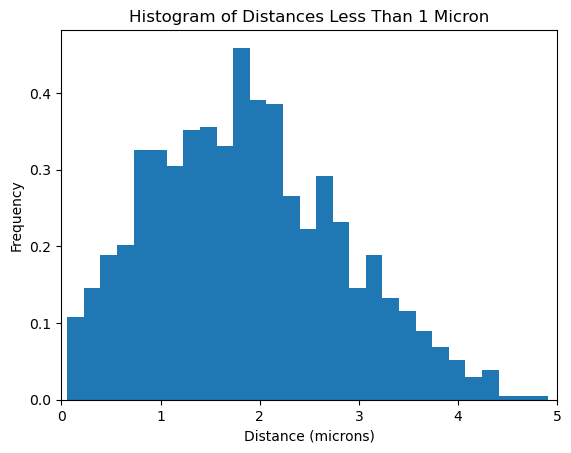

In [188]:
# Make Histogram of distances
# Print number of distances
print(f"Number of distances: {len(distances_df)}")
# Print number of distances less than 1 micron
print(f"Number of distances less than 1 micron: {len(distances_df[distances_df['distance'] < 1])}")
# Print max and min distances
print(f"Max distance: {distances_df['distance'].max()}")
print(f"Min distance: {distances_df['distance'].min()}")

# Plot histogram of distances less than 1 micron
plt.hist(distances_df["distance"], bins=300, density=True)
plt.xlim(0, 5)
plt.xlabel("Distance (microns)")
plt.ylabel("Frequency")
plt.title("Histogram of Distances Less Than 1 Micron")
plt.show()




In [17]:
nuclear_tracking.reordered_labels

<zarr.core.Array (9, 21, 856, 856) uint32>

Number of spots in frame 7: 126
label                                                                                             168
z                                                                                            6.831584
y                                                                                          630.989388
x                                                                                          327.577594
frame                                                                                               7
t_s                                                                                        127.040859
t_frame                                                                                             6
raw_spot                                            [[[9191, 4500, 257, 1853, 36, 0, 1945, 30, 185...
coordinates_start                                                                    [0, 4, 617, 313]
covariance_matrix                                 

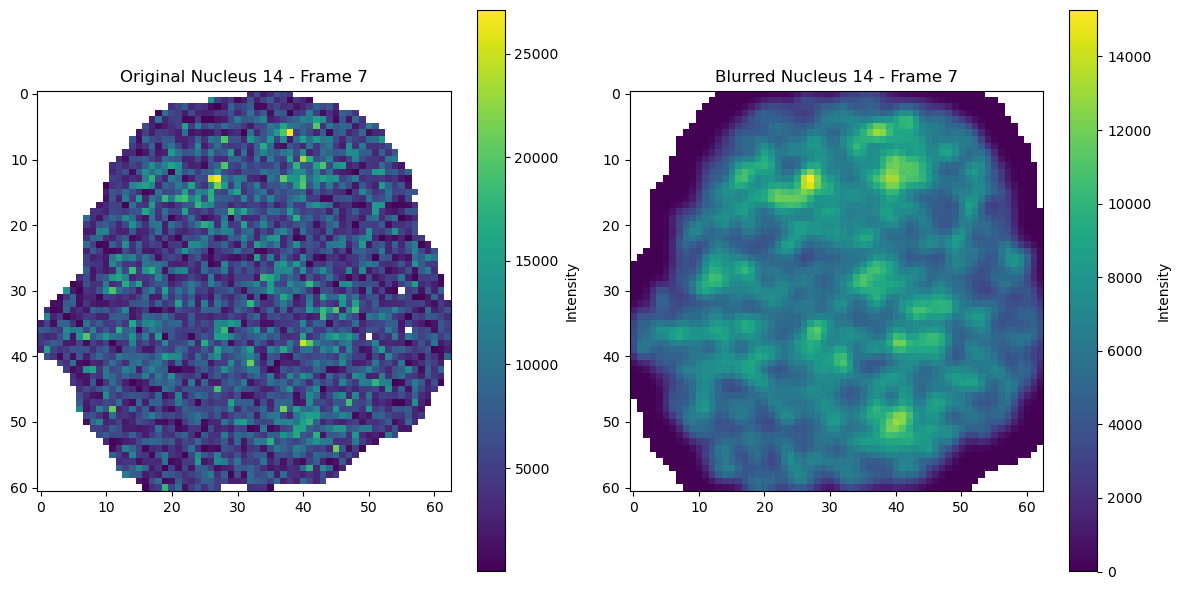

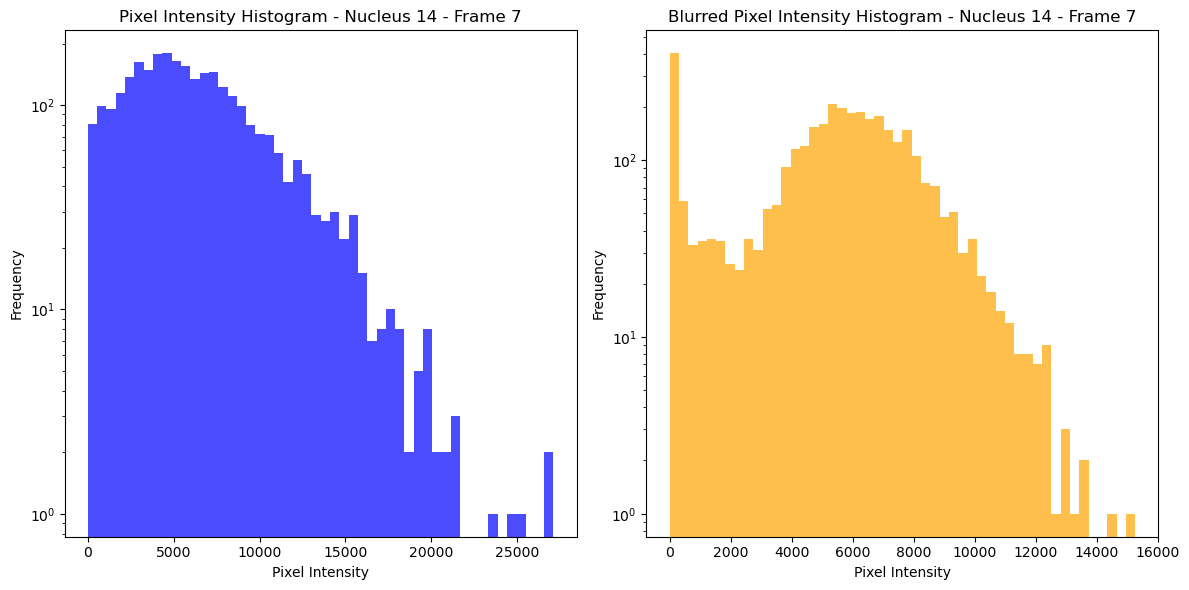

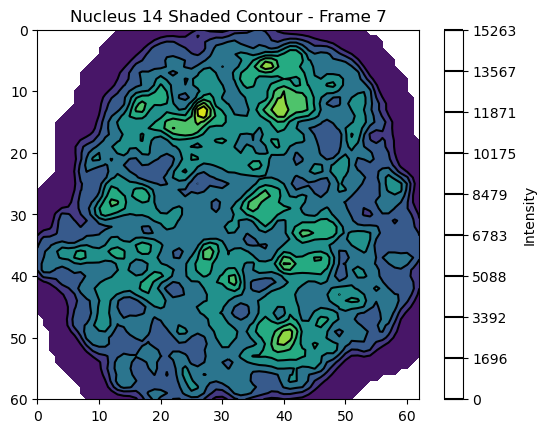

In [197]:
# from skimage.measure import label
import numpy as np
from scipy.spatial.distance import cdist
# Import gaussian filter
from scipy.ndimage import gaussian_filter

frame = 7
detected_spots = spot_df[spot_df["particle"] != 0]
frame_spot_df = detected_spots[detected_spots["frame"] == frame]
# print(frame_spot_df.head())
frame_nuclear_labels = nuclear_tracking.reordered_labels[frame, :, :]
frame_nuclear_data = dataset.channels_full_dataset[nuclear_channel][frame, :, :]
# Print number of spots in the frame
print(f"Number of spots in frame {frame}: {len(frame_spot_df)}")

# # Select nucleus directly... 
# nucleus_id = 14

# ..or select a spot and matches nucleus
example_particle_id = 19
spot = frame_spot_df.loc[frame_spot_df["particle"] == example_particle_id].iloc[0]
#for spot in frame_spot_df.itertuples():  # Iterate through each spot
# Determine which nucleus the spot is in
nucleus_id = nuclear_tracking.reordered_labels[frame, round(spot.z - 0.5), round(spot.y), round(spot.x)]

# Apply mask to the nuclear image to get the nucleus
nucleus_mask = (frame_nuclear_labels == nucleus_id)

# Ensure the mask retains the correct dimensions (avoid collapsing to 1D)
nucleus_mask_data = frame_nuclear_data * nucleus_mask

# Change 0 values to NaN
nucleus_mask_data = np.where(nucleus_mask_data == 0, np.nan, nucleus_mask_data)

z_plane_data = nucleus_mask_data
    
    # Make contour map of the nuclear mask
    
    # threshold = np.nanpercentile(z_plane_data, 99)  # Take the 95th percentile as threshold
    # clusters = (z_plane_data > threshold)
    # # Change 0 values to NaN
    # clusters = np.where(clusters == 0, np.nan, clusters)
    


%matplotlib inline
# Show the nuclear mask for the nucleus containing the spot and the detected Dl clusters
# Zoom in on the nucleus containing the spot
# Extract the 2D slice from nucleus_mask_data and find the bounding box
# Extract the 2D slice from nucleus_mask_data and find the bounding box
nucleus_slice = nucleus_mask_data[8]
non_nan_y, non_nan_x = np.where(~np.isnan(nucleus_slice))
y_min, y_max = non_nan_y.min(), non_nan_y.max()
x_min, x_max = non_nan_x.min(), non_nan_x.max()

# Crop the slice to zoom in on the nucleus
cropped_nucleus_slice = nucleus_slice[y_min:y_max + 1, x_min:x_max + 1]

# Plot the cropped nucleus mask with shading in different contour regions
# Apply a Gaussian blur to the cropped nucleus slice
# Change NaN values to 0 for the Gaussian filter
blurred_nucleus_slice = gaussian_filter(np.nan_to_num(cropped_nucleus_slice), sigma=1 , mode='constant')
# Change 0 values back to NaN
blurred_nucleus_slice = np.where(blurred_nucleus_slice == 0, np.nan, blurred_nucleus_slice)
# plt.figure(figsize=(12, 6))
contour_levels = np.linspace(np.nanmin(blurred_nucleus_slice), np.nanmax(blurred_nucleus_slice),10)#np.nanpercentile(blurred_nucleus_slice, np.linspace(0, 100, 10))

# Set up the subplot figure with two columns
plt.figure(figsize=(12, 6))

# Plot the original version in the first subplot
plt.subplot(1, 2, 1)
plt.imshow(cropped_nucleus_slice, cmap='viridis')
plt.title(f"Original Nucleus {nucleus_id} - Frame {frame}")
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label="Intensity")

# Plot the Gaussian-blurred version in the second subplot
plt.subplot(1, 2, 2)
plt.imshow(blurred_nucleus_slice, cmap='viridis')
plt.title(f"Blurred Nucleus {nucleus_id} - Frame {frame}")
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label="Intensity")

# Show the plots
plt.tight_layout()
plt.show()

# Show histogram of pixel intensities for cropped_nucleus_slice and blurred_nucleus_slice
plt.figure(figsize=(12, 6))

# Plot the histogram of pixel intensities for the cropped nucleus slice
plt.subplot(1, 2, 1)
plt.hist(cropped_nucleus_slice[~np.isnan(cropped_nucleus_slice)], bins=50, color='blue', alpha=0.7)
plt.title(f"Pixel Intensity Histogram - Nucleus {nucleus_id} - Frame {frame}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.yscale('log')

# Plot the histogram of pixel intensities for the blurred nucleus slice
plt.subplot(1, 2, 2)
plt.hist(blurred_nucleus_slice[~np.isnan(blurred_nucleus_slice)], bins=50, color='orange', alpha=0.7)
plt.title(f"Blurred Pixel Intensity Histogram - Nucleus {nucleus_id} - Frame {frame}")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.yscale('log')

# Show the histograms
plt.tight_layout()
plt.show()

# plt.imshow(cropped_nucleus_slice, cmap='viridis')
# plt.title(f"Nucleus {nucleus_id} - Frame {frame}")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.show()


# Fill contour regions with colors
plt.contourf(blurred_nucleus_slice, levels=contour_levels, cmap='viridis')
plt.contour(blurred_nucleus_slice, levels=contour_levels, colors='black')# You can choose other colormaps, like 'plasma' or 'inferno'
plt.colorbar(label="Intensity")
plt.title(f"Nucleus {nucleus_id} Shaded Contour - Frame {frame}")
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis()
plt.show()




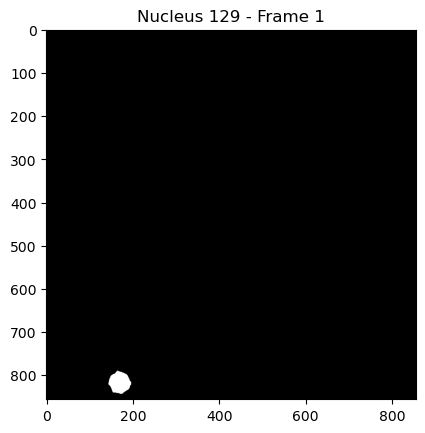

IndexError: unsupported selection item for basic indexing; expected integer or slice, got <class 'numpy.ndarray'>

In [59]:
import matplotlib.pyplot as plt

# Define the nucleus ID and frame index
nucleus_id = 129
frame_index = 1

# Access the specific frame from the Zarr array without loading everything into memory
frame_data = nuclear_tracking.reordered_labels[frame_index, :, :]

# Create a mask for nucleus 79 in this frame
nucleus_mask = (frame_data == nucleus_id)

# Plot the masked frame
%matplotlib inline
plt.imshow(nucleus_mask[17], cmap='gray')  # Display only the mask for nucleus 79
plt.title(f"Nucleus {nucleus_id} - Frame {frame_index}")
plt.show()

# Plot the masked original data
print(dataset.channels_full_dataset[nuclear_channel][nucleus_mask].shape)


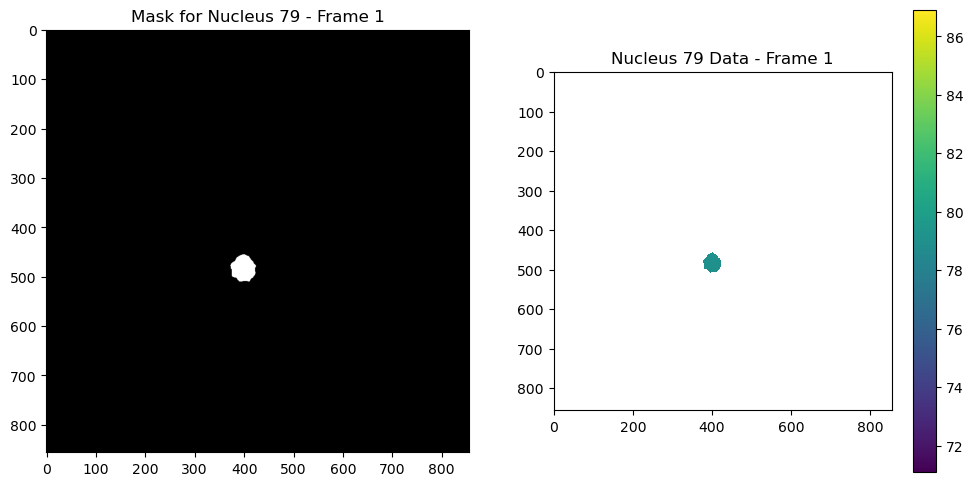

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Define the nucleus ID and a valid frame index (e.g., within 0 to 8)
nucleus_id = 79
frame_index = 1  # Adjust to be within the available range
z_slice = 17

# Access the specific frame from the Zarr array without loading everything into memory
frame_data = nuclear_tracking.reordered_labels[frame_index, :, :]

# Create a mask for nucleus 79 in this frame
nucleus_mask = (frame_data == nucleus_id)

# Create a masked version of the original data where only nucleus 79 is visible
masked_frame_data = np.where(nucleus_mask, frame_data, np.nan)  # Use NaN to hide other nuclei

# Plot both the mask and the masked original data
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the mask
axes[0].imshow(nucleus_mask[z_slice,:,:], cmap='gray')
axes[0].set_title(f"Mask for Nucleus {nucleus_id} - Frame {frame_index}")

# Plot the original data with only nucleus 79 visible
im = axes[1].imshow(masked_frame_data[z_slice,:,:], cmap='viridis')
axes[1].set_title(f"Nucleus {nucleus_id} Data - Frame {frame_index}")
fig.colorbar(im, ax=axes[1])

plt.show()


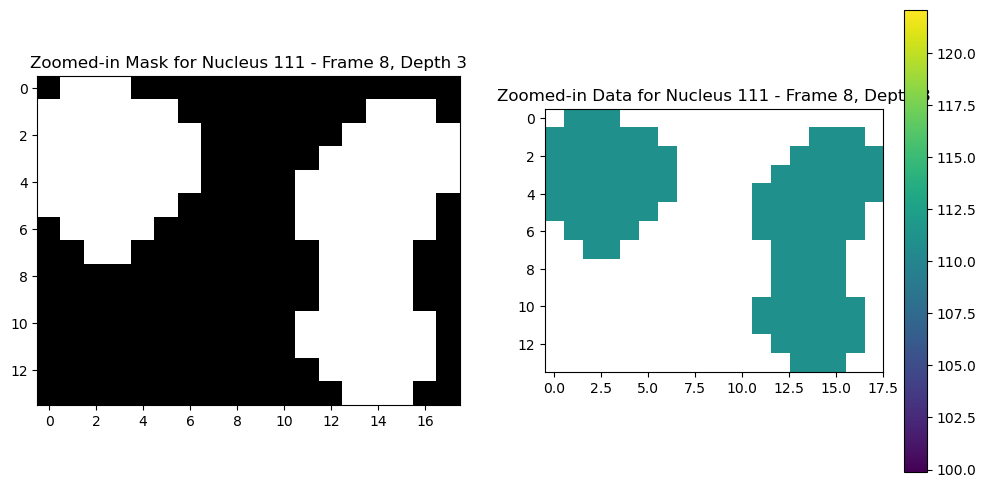

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Define the nucleus ID, frame index, and depth slice
nucleus_id = 111
frame_index = 8   # Choose a valid frame index within the range
depth_index = 3   # Choose a valid depth index within the range

# Access the specific frame and depth from the Zarr array
frame_data = nuclear_tracking.reordered_labels[frame_index, depth_index, :, :]

# Create a mask for nucleus 79 in this depth slice
nucleus_mask = (frame_data == nucleus_id)

# Find the bounding box around nucleus 79 in this slice
y_indices, x_indices = np.where(nucleus_mask)
y_min, y_max = y_indices.min(), y_indices.max()
x_min, x_max = x_indices.min(), x_indices.max()

# Crop the original frame data and mask to this bounding box
cropped_frame_data = frame_data[y_min:y_max+1, x_min:x_max+1]
cropped_nucleus_mask = nucleus_mask[y_min:y_max+1, x_min:x_max+1]

# Plot both the cropped mask and the cropped original data
%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the cropped mask
axes[0].imshow(cropped_nucleus_mask, cmap='gray')
axes[0].set_title(f"Zoomed-in Mask for Nucleus {nucleus_id} - Frame {frame_index}, Depth {depth_index}")

# Plot the cropped original data with only nucleus 79 visible
im = axes[1].imshow(np.where(cropped_nucleus_mask, cropped_frame_data, np.nan), cmap='viridis')
axes[1].set_title(f"Zoomed-in Data for Nucleus {nucleus_id} - Frame {frame_index}, Depth {depth_index}")
fig.colorbar(im, ax=axes[1])

plt.show()
